In [1]:
import numpy as np
import pandas as pd

def read_column_from_csv(file_path: str, col: int = 1) -> np.ndarray:
    df = pd.read_csv(file_path, header=None)
    if df.shape[1] <= col:
        raise ValueError(f"{file_path} has only {df.shape[1]} columns, but col={col} was requested.")
    x = pd.to_numeric(df.iloc[:, col], errors="coerce").dropna().to_numpy(dtype=np.float64)
    return x

def pit_to_uniform(x: np.ndarray) -> np.ndarray:
    """
    PIT via empirical mid-ranks: u_t = (rank_mid(x_t)-0.5)/n in (0,1)
    """
    x = np.asarray(x, dtype=np.float64)
    n = x.size
    if n == 0:
        return x

    order = np.argsort(x, kind="mergesort")
    xs = x[order]

    # Find tie blocks
    diffs = np.diff(xs)
    starts = np.r_[0, np.where(diffs != 0)[0] + 1]
    ends = np.r_[starts[1:], n]

    midranks_sorted = np.empty(n, dtype=np.float64)
    for s, e in zip(starts, ends):
        avg_rank = 0.5 * ((s + 1) + e)   # ranks are 1..n
        midranks_sorted[s:e] = avg_rank

    midranks = np.empty(n, dtype=np.float64)
    midranks[order] = midranks_sorted

    u = (midranks - 0.5) / n
    return u

def uavm_integral_from_u(u: np.ndarray) -> float:
    """
    Exact ∫_0^1 |F_n(t) - t| dt for empirical CDF of u in [0,1].
    """
    u = np.clip(np.asarray(u, dtype=np.float64), 0.0, 1.0)
    n = u.size
    if n == 0:
        return np.nan

    us = np.sort(u)
    a = np.concatenate(([0.0], us))
    b = np.concatenate((us, [1.0]))
    k = np.arange(0, n + 1, dtype=np.float64)
    c = k / n  # value of F_n on each interval

    mask_left = c <= a
    mask_right = c >= b
    mask_mid = ~(mask_left | mask_right)

    I = np.zeros(n + 1, dtype=np.float64)

    # c <= a: ∫(t - c) dt
    if np.any(mask_left):
        aa = a[mask_left] - c[mask_left]
        bb = b[mask_left] - c[mask_left]
        I[mask_left] = (bb * bb - aa * aa) / 2.0

    # c >= b: ∫(c - t) dt
    if np.any(mask_right):
        aa = c[mask_right] - a[mask_right]
        bb = c[mask_right] - b[mask_right]
        I[mask_right] = (aa * aa - bb * bb) / 2.0

    # a < c < b: split at c
    if np.any(mask_mid):
        aa = c[mask_mid] - a[mask_mid]
        bb = b[mask_mid] - c[mask_mid]
        I[mask_mid] = (aa * aa + bb * bb) / 2.0

    return float(I.sum())

def moving_block_bootstrap(u: np.ndarray, block_len: int, rng: np.random.Generator) -> np.ndarray:
    """
    Circular moving-block bootstrap. block_len=1 gives i.i.d. resampling.
    """
    u = np.asarray(u, dtype=np.float64)
    n = u.size
    if block_len < 1:
        raise ValueError("block_len must be >= 1")
    if block_len == 1:
        return u[rng.integers(0, n, size=n)]

    num_blocks = int(np.ceil(n / block_len))
    starts = rng.integers(0, n, size=num_blocks)
    offsets = np.arange(block_len, dtype=np.int64)
    idx = (starts[:, None] + offsets[None, :]) % n
    boot = u[idx].ravel()[:n]
    return boot

def simulate_uavm_distribution_from_path(
    file_path: str,
    col: int = 1,
    lag_len: int = 10,         # interpreted as block length
    n_sims: int = 300,
    seed: int = 0,
    divide_by_sqrt_n: bool = True
):
    """
    Simulate the distribution of the pooled-UAVM statistic based on ONE path.

    Returns:
      sims: simulated values (UAVM / sqrt(n) if divide_by_sqrt_n else UAVM)
      base: the statistic for the original path (same scaling as sims)
      n: sample size
      u: PIT series (useful for diagnostics)
    """
    x = read_column_from_csv(file_path, col=col)
    u = pit_to_uniform(x)
    n = u.size

    base = uavm_integral_from_u(u)
    if divide_by_sqrt_n:
        base = base / np.sqrt(n)

    rng = np.random.default_rng(seed)
    sims = np.empty(n_sims, dtype=np.float64)

    for b in range(n_sims):
        ub = moving_block_bootstrap(u, block_len=lag_len, rng=rng)
        stat = uavm_integral_from_u(ub)
        if divide_by_sqrt_n:
            stat = stat / np.sqrt(n)
        sims[b] = stat

    return sims, base, n, u

def acf(x: np.ndarray, max_lag: int = 100) -> np.ndarray:
    """
    Sample autocorrelation up to max_lag (inclusive), lag 0 = 1.
    """
    x = np.asarray(x, dtype=np.float64)
    x = x - np.mean(x)
    denom = np.dot(x, x)
    out = np.empty(max_lag + 1, dtype=np.float64)
    out[0] = 1.0
    for k in range(1, max_lag + 1):
        out[k] = np.dot(x[:-k], x[k:]) / denom
    return out


Using: paths1/-0.002715154314728352--1.2397481400884827--2.920428962672438-2.5893351117209313.csv


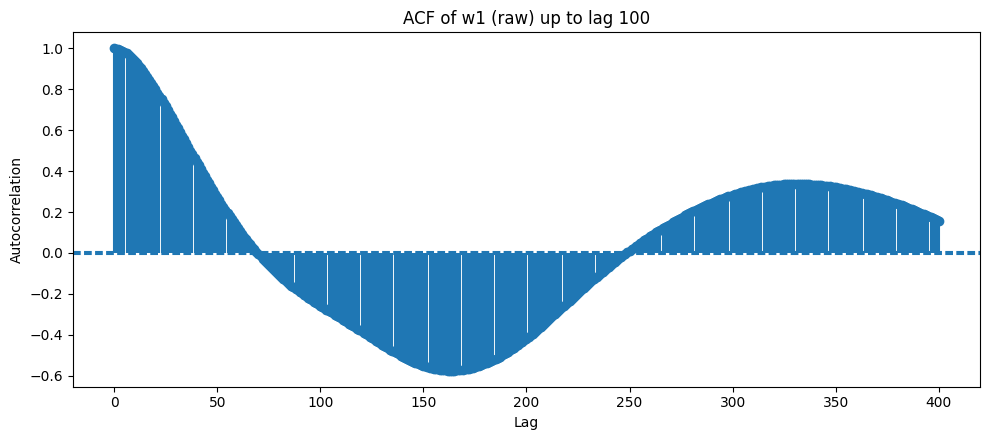

n = 100,002  |  iid-style 95% bounds: ±0.0062


In [6]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

# pick one file from paths1/
files = sorted(glob.glob(os.path.join("paths1", "*.csv")))
if not files:
    raise FileNotFoundError("No CSV files found in paths1/. Check your working directory.")

file_path = files[0]
print("Using:", file_path)

# ACF on raw w1 (second column)
w1 = read_column_from_csv(file_path, col=1)
ac = acf(w1, max_lag=400)
n = w1.size
conf = 1.96 / np.sqrt(n)

plt.figure(figsize=(10, 4.5))
plt.stem(range(len(ac)), ac, basefmt=" ")
plt.axhline(conf, linestyle="--")
plt.axhline(-conf, linestyle="--")
plt.title("ACF of w1 (raw) up to lag 100")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

print(f"n = {n:,}  |  iid-style 95% bounds: ±{conf:.4f}")


Using: paths1/-0.002715154314728352--1.2397481400884827--2.920428962672438-2.5893351117209313.csv


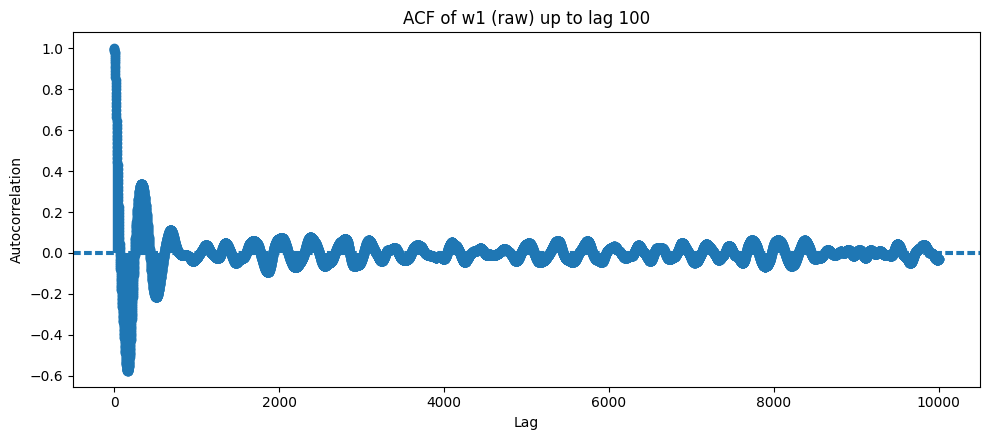

n = 100,002  |  iid-style 95% bounds: ±0.0062


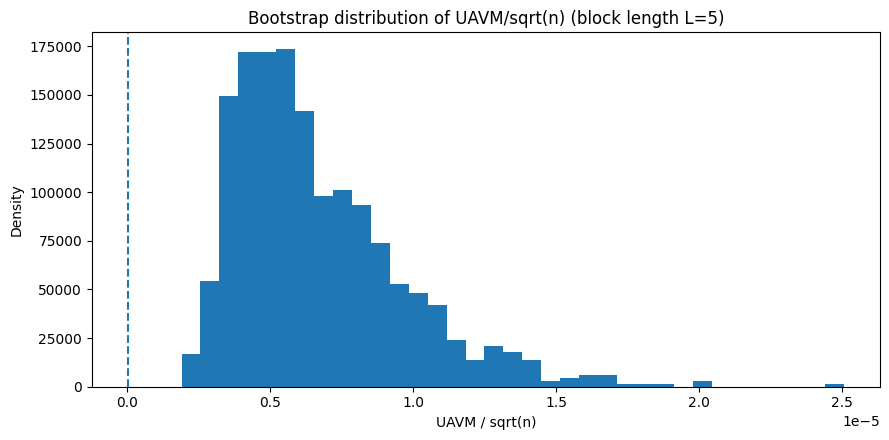

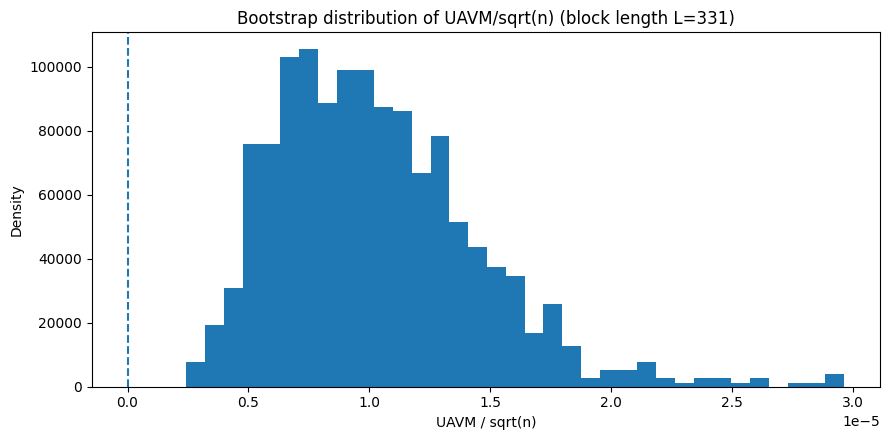

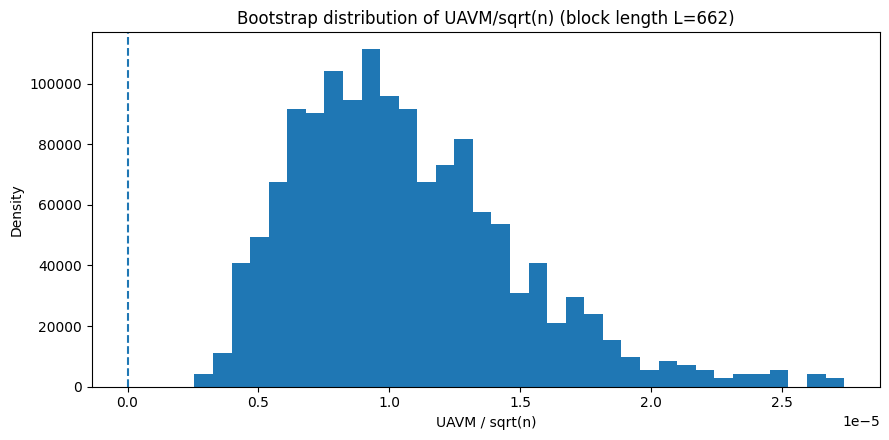

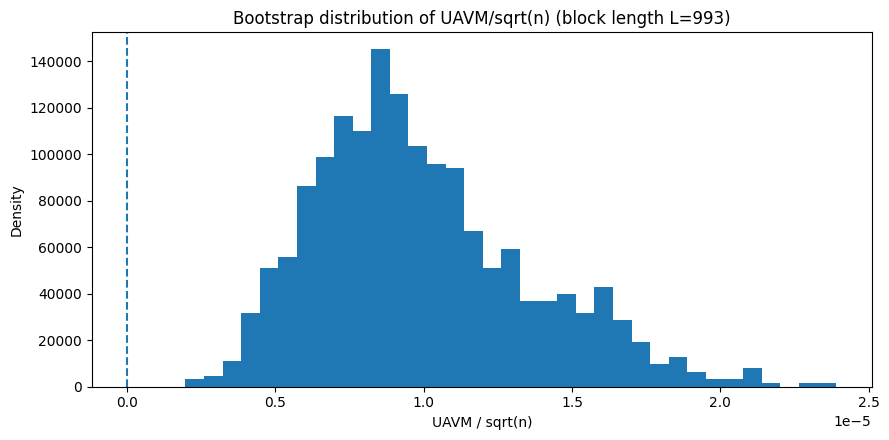

In [8]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

# pick one file from paths1/
files = sorted(glob.glob(os.path.join("paths1", "*.csv")))
if not files:
    raise FileNotFoundError("No CSV files found in paths1/. Check your working directory.")

file_path = files[0]
print("Using:", file_path)

# ACF on raw w1 (second column)
w1 = read_column_from_csv(file_path, col=1)
ac = acf(w1, max_lag=10000)
n = w1.size
conf = 1.96 / np.sqrt(n)

plt.figure(figsize=(10, 4.5))
plt.stem(range(len(ac)), ac, basefmt=" ")
plt.axhline(conf, linestyle="--")
plt.axhline(-conf, linestyle="--")
plt.title("ACF of w1 (raw) up to lag 100")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

print(f"n = {n:,}  |  iid-style 95% bounds: ±{conf:.4f}")

# Bootstrap distributions for different lag_len (block lengths)
lags = [5, 331, 662, 993]
n_sims = 1000

for L in lags:
    sims, base, n, u = simulate_uavm_distribution_from_path(
        file_path=file_path,
        col=1,
        lag_len=L,
        n_sims=n_sims,
        seed=0,
        divide_by_sqrt_n=True  # matches your earlier "maybe divide by sqrt(n)"
    )

    plt.figure(figsize=(9, 4.5))
    plt.hist(sims, bins=35, density=True)
    plt.axvline(base, linestyle="--")
    plt.title(f"Bootstrap distribution of UAVM/sqrt(n) (block length L={L})")
    plt.xlabel("UAVM / sqrt(n)")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


In [7]:
import numpy as np

def estimate_period_from_acf(acf_vals, min_lag=5):
    """
    Rough period estimate for oscillatory ACF:
    find the largest positive local maximum after lag 0.
    Returns estimated period in lags (int) or None if not found.
    """
    a = np.asarray(acf_vals)
    # local maxima: a[k-1] < a[k] > a[k+1]
    peaks = []
    for k in range(min_lag, len(a)-1):
        if a[k] > a[k-1] and a[k] > a[k+1] and a[k] > 0:
            peaks.append(k)
    if not peaks:
        return None
    # pick the peak with the largest height
    best = max(peaks, key=lambda k: a[k])
    return int(best)

def suggest_block_lengths_from_period(P):
    if P is None:
        return [10, 20, 50, 100]
    return [max(1, P), 2*P, 3*P]

# Example usage on your one file:
file_path = files[0]   # from earlier cell
w1 = read_column_from_csv(file_path, col=1)
ac = acf(w1, max_lag=500)     # go beyond 400 if needed
P = estimate_period_from_acf(ac, min_lag=10)
print("Estimated dominant period P:", P)
print("Suggested block lengths:", suggest_block_lengths_from_period(P))


Estimated dominant period P: 331
Suggested block lengths: [331, 662, 993]
